In [63]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsas
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
from brokenaxes import brokenaxes
import pingouin as pg
import colorsys

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_COLOR_DESAT = '#D98C90'
CR_COLOR_DESAT = '#A0A0A0'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#,'#6ded94','#50d979','#36bf5f']

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28']

retroanimals = ['PB_86','BS_86','PB_92','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165']
did_learn = ['BS_92','BS_103','BS_111','BS_179']
did_not_learn = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
indeterminate = ['BS_139','BS_165','BS_191','BS_192']


#BS_59
dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']#,'DS_15','DS_19']
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','TH_217','AE_235','AE_236','TH_237']
unuseddualanimals = ['BS_78']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28','DS_16','DS_17','DS_22','DS_13','DS_23']

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = 'D:\\Analysis_Cache'# - Copy before removing lickdelayrelativetostart'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'P:\\Behavioor'

stim25sdecodingfilename = 'D:\\stimdecoding_25s.csv'
stim25sopsinondecodingfilename = 'D:\\stimdecoding_25s_opsin_on.csv'
stim25sopsinoffdecodingfilename = 'D:\\stimdecoding_25s_opsin_off.csv'

current_version = 1 #June 22nd, 2023
current_version = 2 #July 11th, 2023
current_version = 3 #July 21th, 2023
current_version = 4 #July 31th, 2023
current_version = 5 #Aug 2nd, 2023
current_version = 6 #Aug 12th, 2023
current_version = 7 #Nov 6th, 2023

stdfont = 14
stdyfrac = 0.06

In [77]:
# animals = np.concatenate((dualanimalnames,['DS_15','DS_19']))
animals = ['BS_51','BS_52','BS_56','BS_59','BS_61']

In [65]:
print(animals)

['BS_40' 'BS_41' 'BS_42' 'BS_49' 'BS_50' 'BS_51' 'BS_56' 'BS_59' 'BS_67'
 'BS_70' 'BS_72' 'BS_87' 'BS_108' 'DS_15' 'DS_19']


In [66]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:359: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


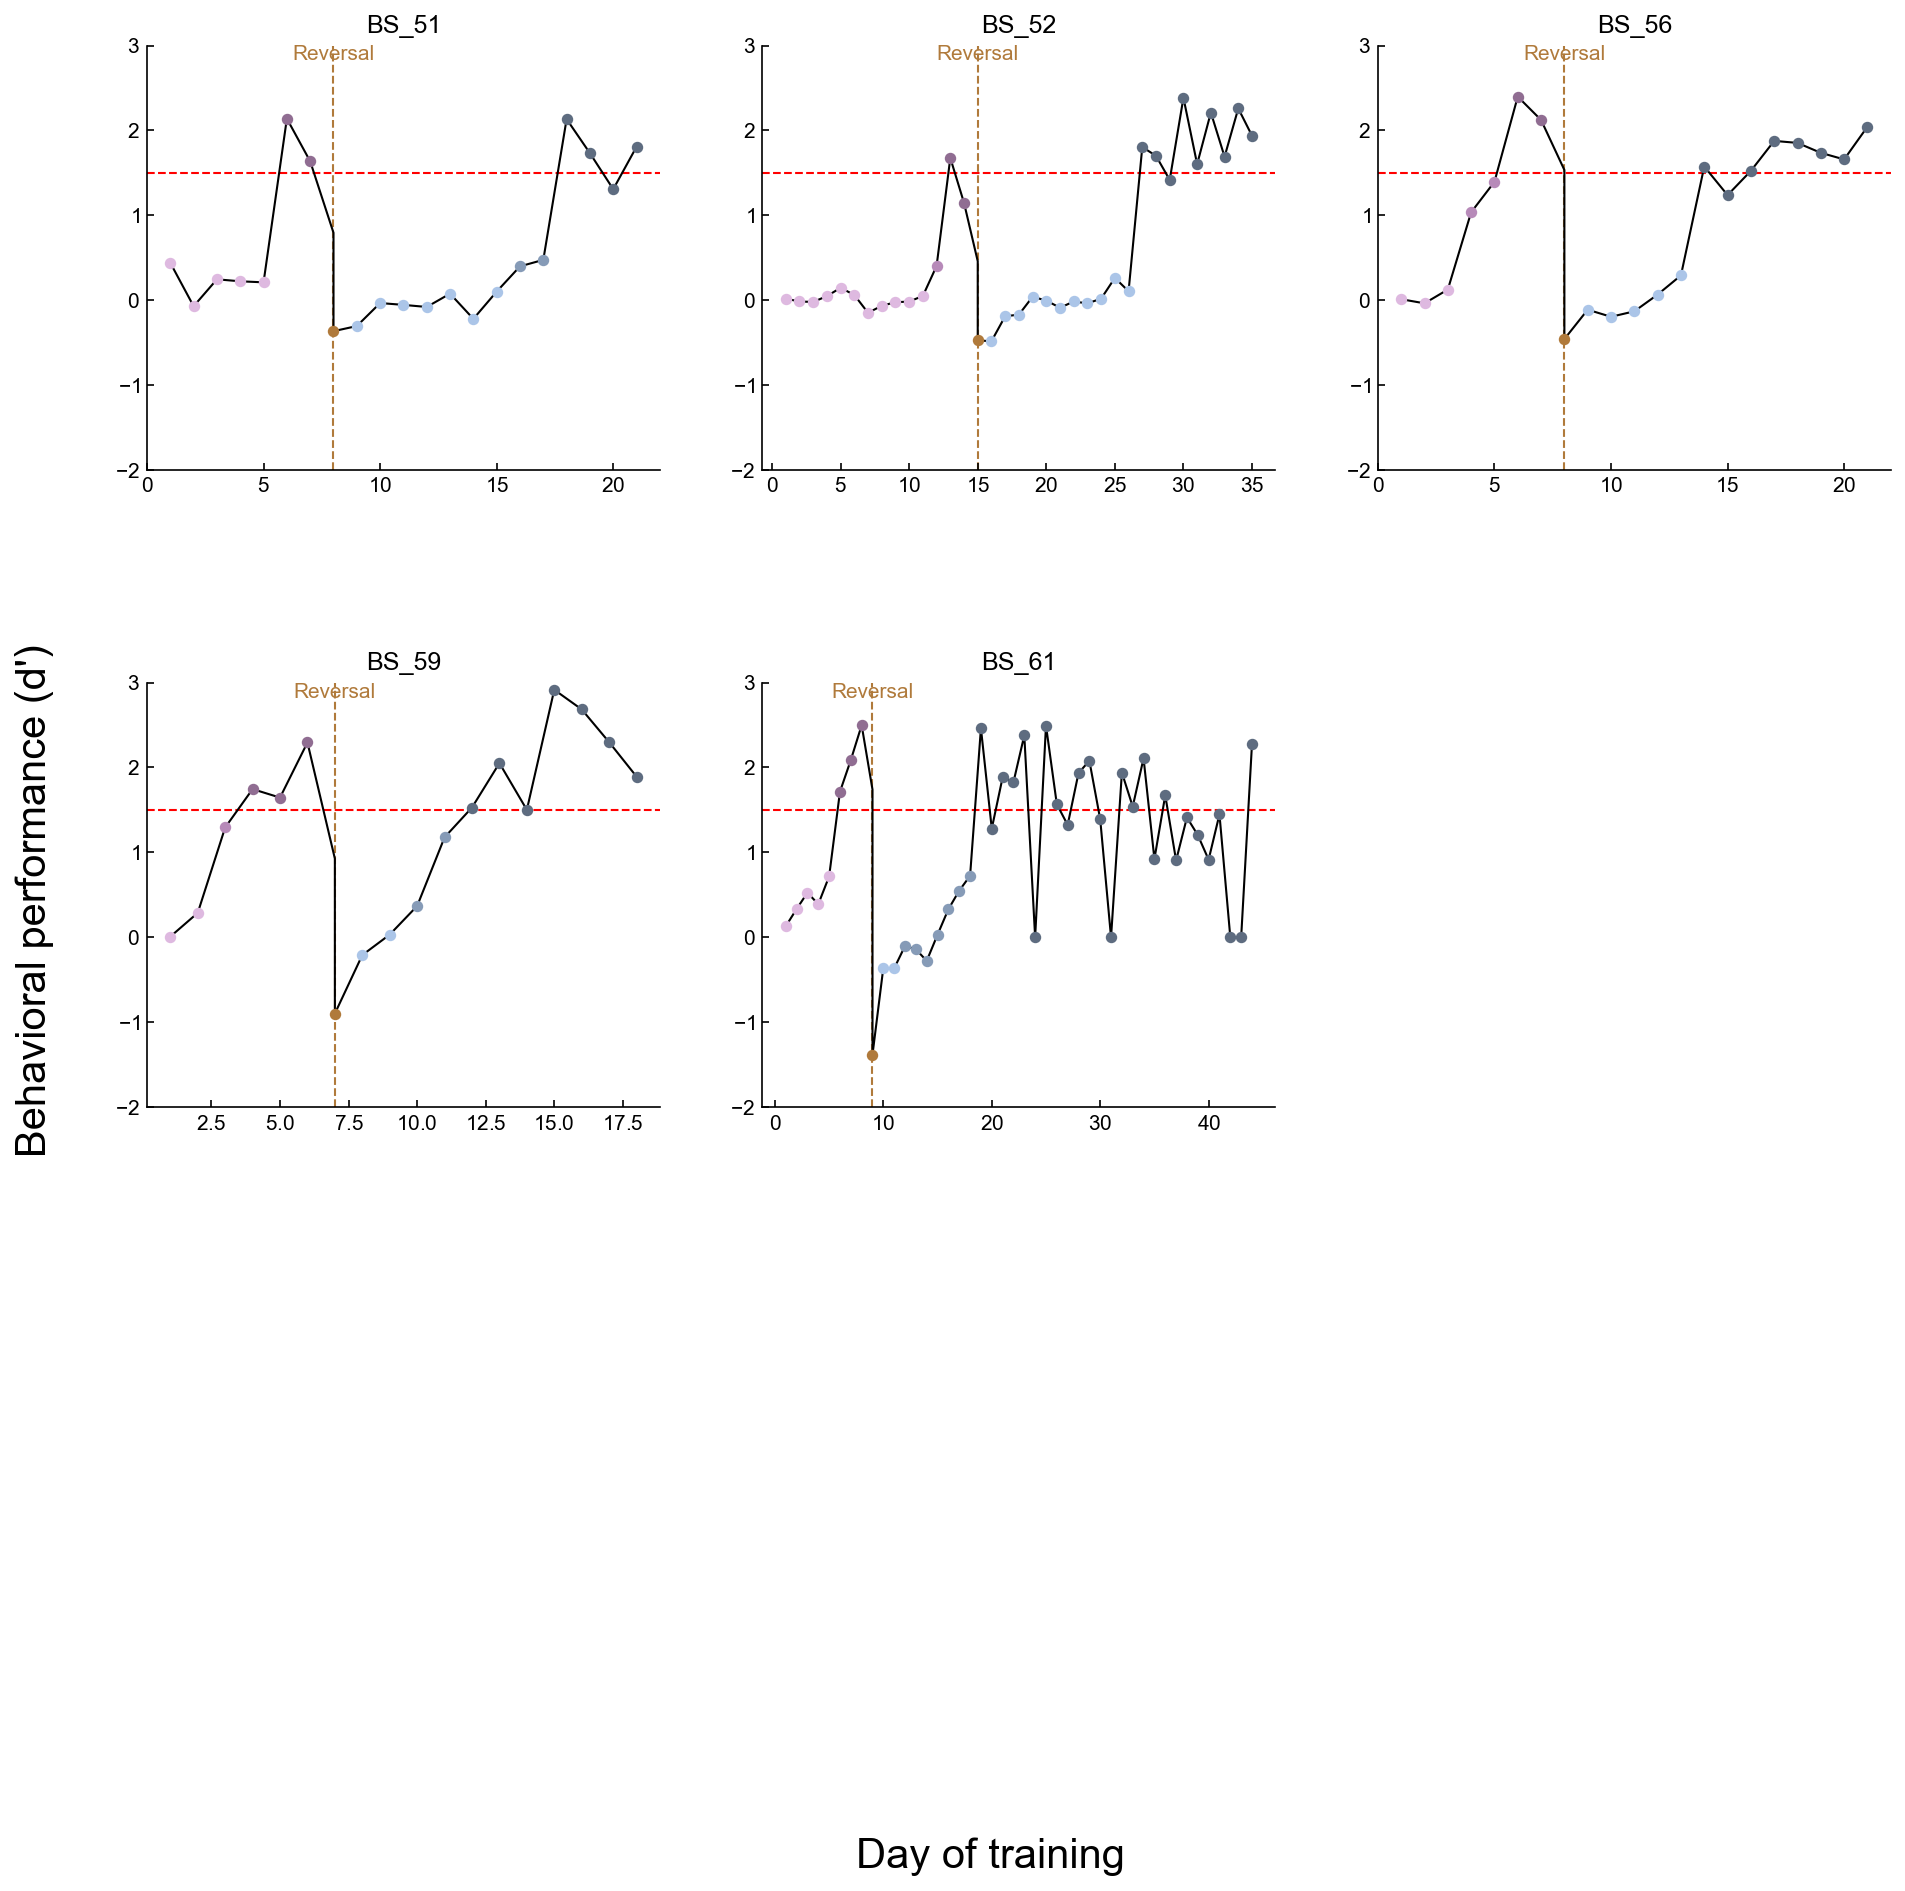

In [78]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)
#plt.savefig(os.path.join('D:\\\\TempFigures','All ephys animals learning phases.pdf'),transparent=False,facecolor="white")

In [90]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in animals:
        continue
    
    if sessionfile.meta.animal == 'BS_59':
        print('A')
    
#     EnumSession.append(session)
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 740/740 [00:09<00:00, 79.19it/s] 


In [84]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 27/27 [00:00<00:00, 293.40it/s]

errors for: []


In [85]:
FRmod_preearly = []
FRmod_prelate = []
FRmod_preexpert = []
FRmod_postearly = []
FRmod_postlate = []
FRmod_postexpert = []
FRmod_switch = []

# Ramping_preearly = []
# Ramping_prelate = []
# Ramping_preexpert = []
# Ramping_postearly = []
# Ramping_postlate = []
# Ramping_postexpert = []

preearly_animals = []
prelate_animals = []
preexpert_animals = []
postearly_animals = []
postlate_animals = []
postexpert_animals = []

cellstouseFR = 'all cells'
# cellstouseFR = 'task encoders'

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    #Currently not active as tuning curve animals have not been decoded
    if cellstouseFR == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
        
#     if sessionfile.responsiveness[clust]['all_trials'].FR < sessionfile.responsiveness[clust]['all_trials'].FRbaseline:
#         #print('excluded')
#         #continue
#         pass
    
    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
        
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    except Exception as e:
        FRmod = np.nan
        print(e)
        
    if np.isnan(FRmod):
        print(f"session {session} cluster {clust} in phase {EILphases[idx]} has nan")
        
    if FRmod > 100:
        print(f"session {session} cluster {clust} in phase {EILphases[idx]} has FRmod {FRmod}")
        
    if EILphases[idx] == 'switch':
        FRmod_switch.append(FRmod)
#         Ramping_switch.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        #preearly_animals.append(sessionfile.meta.animal)
    if EILphases[idx] == 'pre early':
        FRmod_preearly.append(FRmod)
#         Ramping_preearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        preearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre late':
        FRmod_prelate.append(FRmod)
#         Ramping_prelate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        prelate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre expert':
        FRmod_preexpert.append(FRmod)
#         Ramping_preexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        preexpert_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post early':
        FRmod_postearly.append(FRmod)
#         Ramping_postearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        postearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post late':
        FRmod_postlate.append(FRmod)
#         Ramping_postlate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        postlate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post expert':
        FRmod_postexpert.append(FRmod)
#         Ramping_postexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        postexpert_animals.append(sessionfile.meta.animal)

FRmod_preearly = np.array(FRmod_preearly)
FRmod_prelate = np.array(FRmod_prelate)
FRmod_preexpert = np.array(FRmod_preexpert)
FRmod_postearly = np.array(FRmod_postearly)
FRmod_postlate = np.array(FRmod_postlate)
FRmod_postexpert = np.array(FRmod_postexpert)

# Ramping_preearly = np.array(Ramping_preearly)
# Ramping_prelate = np.array(Ramping_prelate)
# Ramping_preexpert = np.array(Ramping_preexpert)
# Ramping_postearly = np.array(Ramping_postearly)
# Ramping_postlate = np.array(Ramping_postlate)
# Ramping_postexpert = np.array(Ramping_postexpert)

27it [00:00, 310.28it/s]

session BS_56_1_AC.pickle cluster 25 in phase post expert has nan


In [32]:
preearly_animals

['BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',
 'BS_49',


In [86]:
print(len(np.unique(preearly_animals)))
print(len(np.unique(prelate_animals)))
print(len(np.unique(preexpert_animals)))
print(len(np.unique(postearly_animals)))
print(len(np.unique(postlate_animals)))
print(len(np.unique(postexpert_animals)))

0
0
0
0
0
2


In [87]:
len(np.unique(np.concatenate([preearly_animals,prelate_animals,preexpert_animals,postearly_animals,postlate_animals,postexpert_animals])))

2

In [88]:
np.unique(np.concatenate([preearly_animals,prelate_animals,preexpert_animals,postearly_animals,postlate_animals]))

array([], dtype=float64)

In [89]:
np.unique(np.concatenate([preearly_animals,prelate_animals,preexpert_animals,postearly_animals,postlate_animals,postexpert_animals]))

array(['BS_51', 'BS_56'], dtype='<U32')

In [44]:
np.sum(np.isfinite(FRmod_postearly))

306

In [45]:
data = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]

n = [len(l) for l in data]
print(n)

n = [print(np.sum(np.isfinite(l))) for l in data]
print(n)

[148, 188, 117, 306, 342, 262]
148
187
97
306
342
247
[None, None, None, None, None, None]


In [9]:
262-247

15

In [10]:
np.sum([148, 188, 117, 349, 299, 283])

1384

In [11]:
len(FRmod_switch)

124

In [12]:
306+342+262

910

In [13]:
349+299+283

931

In [36]:
print(f"Pre early from {np.nanmin(FRmod_preearly)} to {np.nanmax(FRmod_preearly)}")
print(f"Pre late from {np.nanmin(FRmod_prelate)} to {np.nanmax(FRmod_prelate)}")
print(f"Pre expert from {np.nanmin(FRmod_preexpert)} to {np.nanmax(FRmod_preexpert)}")
print(f"Post early from {np.nanmin(FRmod_postearly)} to {np.nanmax(FRmod_postearly)}")
print(f"Post late from {np.nanmin(FRmod_postlate)} to {np.nanmax(FRmod_postlate)}")
print(f"Post expert from {np.nanmin(FRmod_postexpert)} to {np.nanmax(FRmod_postexpert)}")

Pre early from 0.28906955736224027 to 65.79047619047616
Pre late from 0.18939393939393936 to 56.184971098265905
Pre expert from 0.1 to 67.80487804878047
Post early from 0.30969845150774233 to 130.73333333333332
Post late from 0.26402640264026406 to 50.692167577413485
Post expert from 0.21978021978021983 to 90.45104510451036


In [24]:
print(f"Pre early from {np.median(ilep.rmnan(FRmod_preearly))}")
print(f"Pre late from {np.median(ilep.rmnan(FRmod_prelate))}")
print(f"Pre expert from {np.median(ilep.rmnan(FRmod_preexpert))}")
print(f"Post early from {np.median(ilep.rmnan(FRmod_postearly))}")
print(f"Post late from {np.median(ilep.rmnan(FRmod_postlate))}")
print(f"Post expert from {np.median(ilep.rmnan(FRmod_postexpert))}")

Pre early from 3.5533237685317998
Pre late from 2.54335260115607
Pre expert from 3.34913112164297
Post early from 3.3727151344284865
Post late from 2.172278522392938
Post expert from 2.6911314984709485


# Tone-evoked (FRmodulation)

### V2

baseline = 3.5533237685317998


<ipython-input-44-5e39f0e838db>:15: RuntimeWarning: divide by zero encountered in log10
  X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)


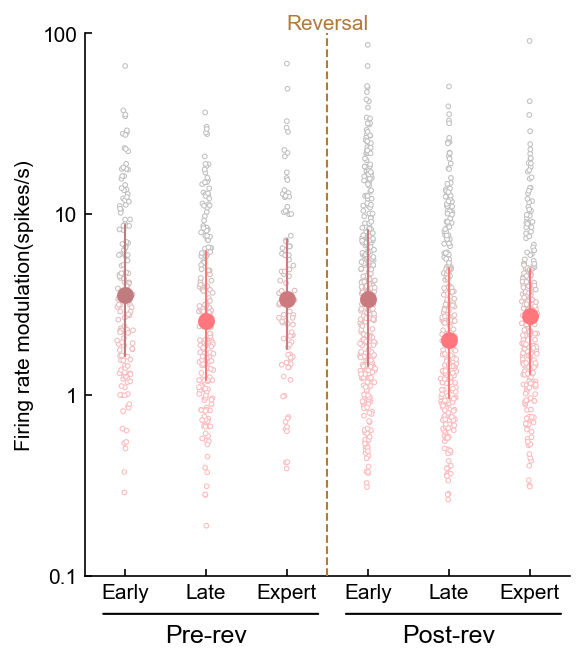

In [44]:
#Firing rate modulation graphs
size=5

FRmod_baseline_median = np.median(FRmod_preearly)
print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
data = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=0.5,zorder=-10)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color=NCR_CR_cmap((percentCR-40)/20)
    border_color = eye_color
    
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
#     border_color=colorsys.hls_to_rgb(h,l*0.5,s)
#     print(border_color)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

    
#Connected lines
# medians = [np.nanmedian(d) for d in data]
# ax.plot([0,1,2],medians[0:3],linestyle='--',color=GOOD_GREY,lw=1)
# ax.plot([3,4,5],medians[3:6],linestyle='--',color=GOOD_GREY,lw=1)

ax.set_ylim([0.1,100])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Firing rate modulation(spikes/s)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, 0.054188468134356925, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
ax.text(xtick_pos_post, 0.054188468134356925, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='k'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='k'))

plt.tight_layout()
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC FRmodulation all cells over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

### V3

baseline = 3.5533237685317998


<ipython-input-59-66c7ee700a0e>:15: RuntimeWarning: divide by zero encountered in log10
  X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)


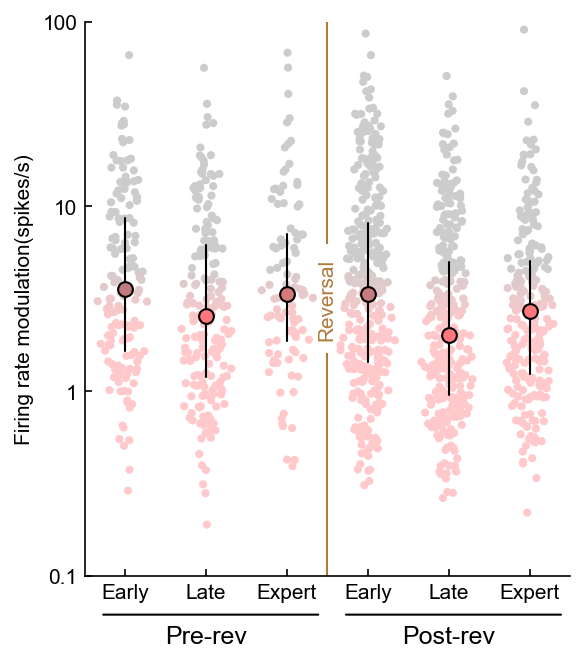

In [59]:
#Firing rate modulation graphs
size=10

FRmod_baseline_median = np.median(FRmod_preearly)
print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
data = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.75,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)

mn = 3.5
spread = 2.5
colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )

ax.scatter(X, Y, s=size, ec=colors, fc=colors, lw=0.75,zorder=-10)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
#     border_color = NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color='k'#'#202020'#colorsys.hls_to_rgb(h,l*0.8,s)
#     print(border_color)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

    
#Connected lines
# medians = [np.nanmedian(d) for d in data]
# ax.plot([0,1,2],medians[0:3],linestyle='--',color=GOOD_GREY,lw=1)
# ax.plot([3,4,5],medians[3:6],linestyle='--',color=GOOD_GREY,lw=1)

ax.set_ylim([0.1,100])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Firing rate modulation(spikes/s)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

#bax.axs[0].text(reversal,ax.get_ylim()[1]+0.2,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='top')
size = 5
rev = 2.5
center = 10**(0.5)#center = np.mean(ax.get_ylim())
ax.text(rev,center,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center',rotation=90)
ax.plot([rev,rev],[ax.get_ylim()[0],center/2],color=SWITCH_COLOR,lw=1,linestyle='-')
ax.plot([rev,rev],[center*2,ax.get_ylim()[1]],color=SWITCH_COLOR,lw=1,linestyle='-')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.60,zorder=-5)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, 0.054188468134356925, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
ax.text(xtick_pos_post, 0.054188468134356925, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='k'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='k'))

plt.tight_layout()
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC FRmodulation all cells over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

### V5

baseline = 3.5533237685317998


<ipython-input-12-0aad0f431225>:15: RuntimeWarning: divide by zero encountered in log10
  X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)


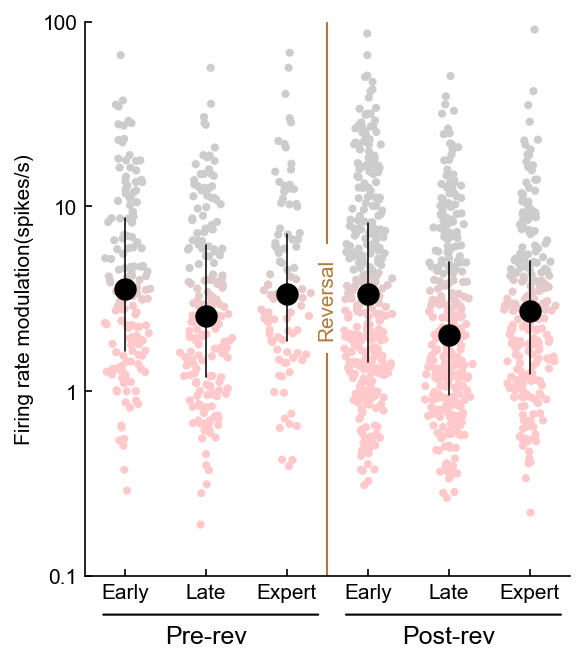

In [12]:
#Firing rate modulation graphs
size=10

FRmod_baseline_median = np.median(FRmod_preearly)
print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
data = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.75,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)

mn = 3.5
spread = 2.5
colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )

ax.scatter(X, Y, s=size, ec=colors, fc=colors, lw=0.75,zorder=-10)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
#     border_color = NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    eye_color='k'
    border_color='k'#'#202020'#colorsys.hls_to_rgb(h,l*0.8,s)
#     print(border_color)

    summary_size=100
    summary_width=0.75
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

    
#Connected lines
# medians = [np.nanmedian(d) for d in data]
# ax.plot([0,1,2],medians[0:3],linestyle='--',color=GOOD_GREY,lw=1)
# ax.plot([3,4,5],medians[3:6],linestyle='--',color=GOOD_GREY,lw=1)

ax.set_ylim([0.1,100])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Firing rate modulation(spikes/s)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

#bax.axs[0].text(reversal,ax.get_ylim()[1]+0.2,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='top')
size = 5
rev = 2.5
center = 10**(0.5)#center = np.mean(ax.get_ylim())
ax.text(rev,center,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center',rotation=90)
ax.plot([rev,rev],[ax.get_ylim()[0],center/2],color=SWITCH_COLOR,lw=1,linestyle='-')
ax.plot([rev,rev],[center*2,ax.get_ylim()[1]],color=SWITCH_COLOR,lw=1,linestyle='-')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.60,zorder=-5)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, 0.054188468134356925, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
ax.text(xtick_pos_post, 0.054188468134356925, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='k'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='k'))

plt.tight_layout()
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC FRmodulation all cells over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

### V6

<ipython-input-15-8aae3e0b3047>:36: RuntimeWarning: divide by zero encountered in log10
  X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)


3.5533237685317998
2.54335260115607
3.34913112164297
3.3727151344284865
2.172278522392938
2.6911314984709485


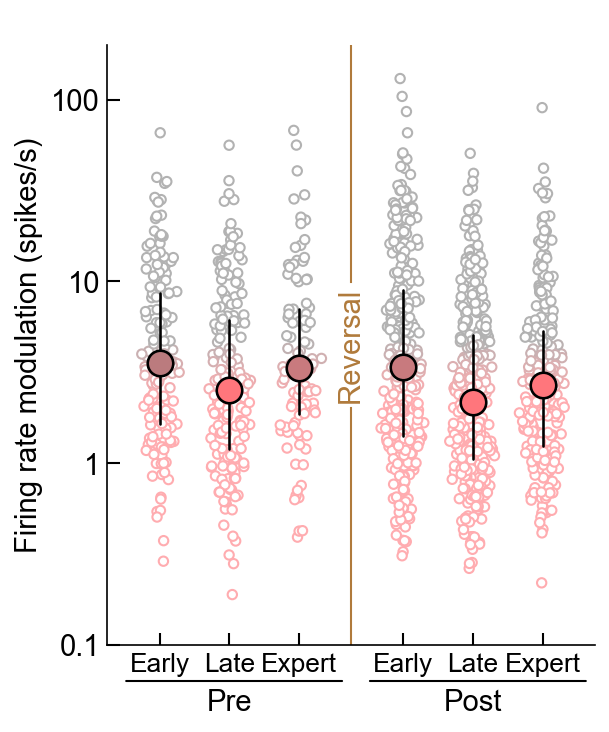

In [15]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=150
summary_width=1.25#0.75

mn = 3.5
spread = 2.5
# colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )
    
###
    
FRmod_baseline_median = 3.5
data = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

###
X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1]))]
_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.75,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)
colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=1,zorder=-10,clip_on=False)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)

    print(median)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')


################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0.1,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ylab = ax.set_ylabel('Firing rate modulation (spikes/s)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=True)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

Y = np.mean(ax.get_ylim())
Y = 10**np.mean(np.log10(ax.get_ylim()))
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]*2]*2,color='white',alpha=0.4,zorder=-5,clip_on=False)

ttl = ax.set_title(' ')
artists = [ylab,t1,t2,ttl]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC FRmodulation all cells over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [38]:
148+187+97+349+299+247

1327

In [46]:
data_dec = SimpleNamespace()
data_dec.preearly = np.abs(FRmod_preearly)
data_dec.prelate = np.abs(FRmod_prelate)
data_dec.preexpert = np.abs(FRmod_preexpert)
data_dec.postearly = np.abs(FRmod_postearly)
data_dec.postlate = np.abs(FRmod_postlate)
data_dec.postexpert = np.abs(FRmod_postexpert)
ilep.mannwhitneycompareall(data_dec)

pre-early   n = 148
pre-late    n = 187
pre-expert  n = 97
post-early  n = 306
post-late   n = 342
post-expert n = 247
pre-early  to pre-late   : 0.017783530816945618
pre-late   to pre-expert : 0.04809034409489487
pre-early  to pre-expert : 0.8371558472745269
post-early to post-late  : 8.285114314539534e-05
post-late  to post-expert: 0.128957782021501
post-early to post-expert: 0.017783530816945618


# Up-Ramping Cells

In [18]:
Ramping_preearly = []
Ramping_prelate = []
Ramping_preexpert = []
Ramping_postearly = []
Ramping_postlate = []
Ramping_postexpert = []

cellstouseFR = 'all cells'
#cellstouseFR = 'task encoders'

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    #Currently not active as tuning curve animals have not been decoded
    if cellstouseFR == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
        
    if sessionfile.responsiveness[clust]['all_trials'].FR < sessionfile.responsiveness[clust]['all_trials'].FRbaseline:
        #print('excluded')
        #continue
        pass
    
    rampingMod = sessionfile.responsiveness[clust]['go'].rampingMod
    if rampingMod <= 0:
        continue
        
    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
        
    if EILphases[idx] == 'pre early':
        Ramping_preearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
    elif EILphases[idx] == 'pre late':
        Ramping_prelate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
    elif EILphases[idx] == 'pre expert':
        Ramping_preexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)
    elif EILphases[idx] == 'post early':
        Ramping_postearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
    elif EILphases[idx] == 'post late':
        Ramping_postlate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
    elif EILphases[idx] == 'post expert':
        Ramping_postexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)

Ramping_preearly = np.array(Ramping_preearly)
Ramping_prelate = np.array(Ramping_prelate)
Ramping_preexpert = np.array(Ramping_preexpert)
Ramping_postearly = np.array(Ramping_postearly)
Ramping_postlate = np.array(Ramping_postlate)
Ramping_postexpert = np.array(Ramping_postexpert)

1682it [00:21, 77.38it/s] 


baseline = 3.5533237685317998


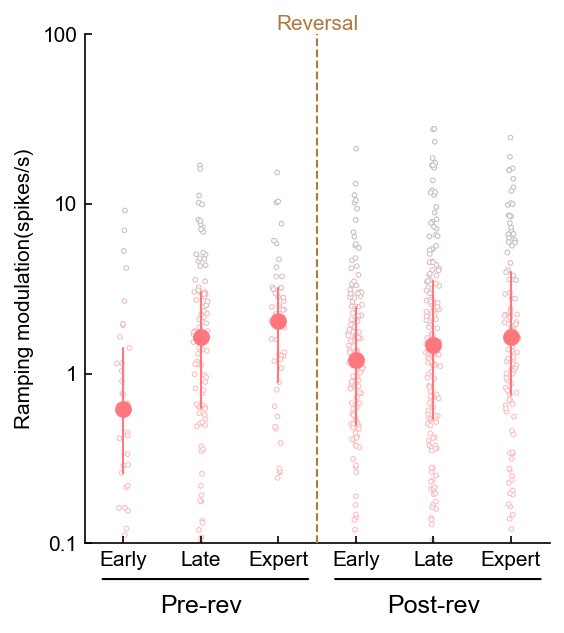

In [12]:
#Firing rate modulation graphs
size=5

FRmod_baseline_median = np.median(FRmod_preearly)
print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
data = [Ramping_preearly,Ramping_prelate,Ramping_preexpert,Ramping_postearly,Ramping_postlate,Ramping_postexpert]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=0.5,zorder=-10)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color=NCR_CR_cmap((percentCR-40)/20)
    border_color = eye_color
    
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
#     border_color=colorsys.hls_to_rgb(h,l*0.5,s)
#     print(border_color)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
#     #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     mean = np.mean(column)
#     SEM = sem(column)
#     Q1 = mean-SEM
#     Q3 = mean+SEM
    
# #     ax.scatter([idx], [mean], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
# #     ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
#     width=0.25
#     ax.plot([idx-width,idx+width],[mean]*2,color='k',lw=1)
#     ax.plot([idx]*2,[mean-SEM,mean+SEM],color='k',lw=1)

ax.set_ylim([0.1,100])
#ax.set_yticks([0.1,1,10,100])
#ax.set_yticklabels(['0.1','1','10','100'])
ticks = [0.1,1,10,100]
ax.set_yticks(ticks)
ax.set_yticklabels([str(s) for s in ticks])
ax.set_ylabel('Ramping modulation(spikes/s)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.axhline(0,color='k',linestyle='--',zorder=10,lw=1)

# #numbers
#cells
# for idx,column in enumerate(data):
#     ax.text(idx,120,str(len(column)))
# #animals
# for idx,column in enumerate(num_animal):
#     ax.text(idx,95,str(column))
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),log=True)+0.0075
t1 = ax.text(xtick_pos_pre, Yval, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='k'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='k'))

#plt.tight_layout()
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC Up-Ramping all cells over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

In [19]:
data_dec = SimpleNamespace()
data_dec.preearly = np.abs(ilep.rmnan(Ramping_preearly))
data_dec.prelate = np.abs(ilep.rmnan(Ramping_prelate))
data_dec.preexpert = np.abs(ilep.rmnan(Ramping_preexpert))
data_dec.postearly = np.abs(ilep.rmnan(Ramping_postearly))
data_dec.postlate = np.abs(ilep.rmnan(Ramping_postlate))
data_dec.postexpert = np.abs(ilep.rmnan(Ramping_postexpert))
ilep.nonparametricIndependentStatsCompareToPreearly(data_dec)


            Source           SS     DF          MS          F     p-unc  \
0            phase   126.371754    4.0   31.592939   2.464931  0.043806   
1          context   233.456279    1.0  233.456279  18.214630  0.000022   
2  phase * context    30.521627    4.0    7.630407   0.595336  0.666114   
3         Residual  9343.567576  729.0   12.816965        NaN       NaN   

        np2  
0  0.013345  
1  0.024377  
2  0.003256  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
11   post-early  baseline  experimental  0.031829  0.031829 -0.237456
12  post-expert  baseline  experimental  0.000787  0.002417 -0.476250
13    post-late  baseline  experimental  0.003657  0.006094 -0.405889
14   pre-expert  baseline  experimental  0.000967  0.002417 -0.492130
15     pre-late  baseline  experimental  0.005515  0.006894 -0.379946


,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-early,post-expert,False,False,11373.5,two-sided,6.707098e-02,0.627498,fdr_bh,-0.284652
1,phase,-,post-early,post-late,False,False,15375.5,two-sided,1.254996e-01,0.627498,fdr_bh,-0.269065
2,phase,-,post-early,pre-expert,False,False,6540.5,two-sided,3.506078e-01,0.795622,fdr_bh,-0.096920
3,phase,-,post-early,pre-late,False,False,11060.5,two-sided,3.035172e-01,0.795622,fdr_bh,-0.110809
4,phase,-,post-expert,post-late,False,False,15099.5,two-sided,7.263385e-01,0.810957,fdr_bh,-0.016217
5,phase,-,post-expert,pre-expert,False,False,6417.5,two-sided,5.848220e-01,0.810957,fdr_bh,0.193971
6,phase,-,post-expert,pre-late,False,False,10947.5,two-sided,3.978110e-01,0.795622,fdr_bh,0.186174
7,phase,-,post-late,pre-expert,False,False,8289.5,two-sided,7.298612e-01,0.810957,fdr_bh,0.186284
8,phase,-,post-late,pre-late,False,False,14030.5,two-sided,6.164578e-01,0.810957,fdr_bh,0.182095
9,phase,-,pre-expert,pre-late,False,False,5713.5,two-sided,9.041030e-01,0.904103,fdr_bh,-0.016481


# Passive

In [54]:
animals_in_cache = []

EnumACSession = []
EnumACClust = []

for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if session in ['TH_203_1_passive_AC.pickle','TH_203_4_passive_AC.pickle','TH_203_7_passive_AC.pickle','LA_204_2_passive_AC.pickle','LA_204_3_passive_AC.pickle','LA_204_4_passive_AC.pickle']:#Outlier sessions
            continue
            
    if sessionfile.meta.animal not in ['TH_201','TH_203','LA_204','LA_205','TH_200', 'TH_230','AE_229','TH_233','TH_234','AE_294']:
        continue
#     if sessionfile.meta.animal not in ['AE_294']:
#         continue
    
    animals_in_cache.append(sessionfile.meta.animal)
    
    for clust in sessionfile.clusters.good:
        if sessionfile.meta.region == "AC":
            EnumACSession.append(session)
            EnumACClust.append(clust)
        
animals_in_cache = np.unique(animals_in_cache)

100%|██████████| 740/740 [00:09<00:00, 78.31it/s] 


In [55]:
#Define 6 learning phases(days)
pre_early = 4
pre_late = 6
pre_expert = 8
post_early = 12
post_late = 15
post_expert = 16

#
FRmod_preearly = []
FRmod_prelate = []
FRmod_preexpert = []
FRmod_postearly = []
FRmod_postlate = []
FRmod_postexpert = []

#
preexpert_session_num = []
postlate_session_num = []
postexpert_session_num = []


In [56]:
preearly_animal = []
prelate_animal = []
preexpert_animal = []
postearly_animal = []
postlate_animal = []
postexpert_animal = []

pre_early_session = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumACSession,EnumACClust))):
    
    if session in ['TH_203_1_passive_AC.pickle','TH_203_4_passive_AC.pickle','TH_203_7_passive_AC.pickle','LA_204_2_passive_AC.pickle','LA_204_3_passive_AC.pickle','LA_204_4_passive_AC.pickle']:#Outlier sessions
        continue
#     if session == 'TH_234_3_passive_AC.pickle' and clust in [40,109]:
#         continue
    
    ACsessionfile = ilep.loadSessionCached(act_directory,session)
    
    #1,2,3,4
    if ACsessionfile.meta.day_of_training <= pre_early:
        FRmod_preearly.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        preearly_animal.append(ACsessionfile.meta.animal)
        pre_early_session.append(session)
#         print(ACsessionfile.meta.files)
#         print(ACsessionfile.meta.directory)
#         print()
        if ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation < 1:
            print(f"{session} clust {clust} is an NCR")
        
    #5,6
    if ACsessionfile.meta.day_of_training <= pre_late and ACsessionfile.meta.day_of_training >pre_early:
        FRmod_prelate.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        prelate_animal.append(ACsessionfile.meta.animal)
    
    #7,8
    if ACsessionfile.meta.day_of_training <= pre_expert and ACsessionfile.meta.day_of_training >pre_late:
        FRmod_preexpert.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        preexpert_session_num.append(ACsessionfile.meta.files)
        preexpert_animal.append(ACsessionfile.meta.animal)
        
    #9,10,11,12
    if ACsessionfile.meta.day_of_training <= post_early and ACsessionfile.meta.day_of_training >pre_expert:
        FRmod_postearly.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        postearly_animal.append(ACsessionfile.meta.animal)

    #13,14,15
    if ACsessionfile.meta.day_of_training <= post_late and ACsessionfile.meta.day_of_training >post_early:
        FRmod_postlate.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        postlate_session_num.append(ACsessionfile.meta.files)
        postlate_animal.append(ACsessionfile.meta.animal)
    
    #16,17,18,19,20,21
    if ACsessionfile.meta.day_of_training >= post_expert:
        print(ACsessionfile.meta.day_of_training)
        FRmod_postexpert.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        postexpert_session_num.append(ACsessionfile.meta.files)
        postexpert_animal.append(ACsessionfile.meta.animal)
    

94it [00:02, 43.63it/s]

16
16
16
16
16
16
16
16
16
16
16


111it [00:02, 60.67it/s]

16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16


125it [00:03, 63.37it/s]

16
16
16
16
16
16
16
16
16
16
16
16
16
16


139it [00:03, 63.09it/s]

16
16
16
16
16
16
16
16
16
16
16
16
16


146it [00:03, 63.59it/s]

16
16
16
16
16
16
16
16
16
16
16
16
16
16


163it [00:03, 73.12it/s]

16
16
16
16
16
16
16
16
16
16
16
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17


214it [00:03, 162.14it/s]

17
17
17
17
17
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
19
19
19
19


231it [00:04, 119.46it/s]

19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19


261it [00:04, 128.02it/s]

19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
20
20
20
20
20
20


290it [00:04, 134.41it/s]

20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20


305it [00:04, 136.06it/s]

20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20


320it [00:04, 130.18it/s]

20
21
21
21
21
21
21
21
21
21
21
21


334it [00:04, 90.30it/s] 

21
21
21
21
21
21
21
21
21
21
21
21
21
21
21


354it [00:05, 63.26it/s]

21
21
21
21
21
21
21
21
21
21


792it [00:09, 237.14it/s]

16
16
16
16
16
16
16
16
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
18
18
18
18
18
19
19
19
19
19
19


817it [00:10, 189.73it/s]

19
19
19
20
TH_201_1_passive_AC.pickle clust 89 is an NCR
TH_201_1_passive_AC.pickle clust 201 is an NCR


857it [00:10, 132.97it/s]

TH_201_2_passive_AC.pickle clust 74 is an NCR


873it [00:10, 116.51it/s]

TH_201_2_passive_AC.pickle clust 167 is an NCR
TH_201_2_passive_AC.pickle clust 204 is an NCR
TH_201_2_passive_AC.pickle clust 231 is an NCR


900it [00:10, 114.07it/s]

TH_201_3_passive_AC.pickle clust 72 is an NCR
TH_201_3_passive_AC.pickle clust 76 is an NCR
TH_201_3_passive_AC.pickle clust 127 is an NCR
TH_201_3_passive_AC.pickle clust 154 is an NCR


926it [00:11, 117.91it/s]

TH_201_3_passive_AC.pickle clust 169 is an NCR
TH_201_3_passive_AC.pickle clust 229 is an NCR
TH_201_3_passive_AC.pickle clust 230 is an NCR


981it [00:11, 158.51it/s]

TH_201_4_passive_AC.pickle clust 70 is an NCR
TH_201_4_passive_AC.pickle clust 79 is an NCR
TH_201_4_passive_AC.pickle clust 224 is an NCR


1022it [00:11, 180.29it/s]

TH_203_2_passive_AC.pickle clust 24 is an NCR
TH_203_2_passive_AC.pickle clust 75 is an NCR
TH_203_2_passive_AC.pickle clust 80 is an NCR
TH_203_2_passive_AC.pickle clust 240 is an NCR
TH_203_2_passive_AC.pickle clust 253 is an NCR
TH_203_3_passive_AC.pickle clust 27 is an NCR


1140it [00:13, 80.07it/s] 

16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16


1181it [00:13, 131.25it/s]

16
16
16
16
16
16
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18


1252it [00:13, 229.08it/s]

18
18
18
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
21
21
21
21
21
21
21


1540it [00:16, 95.89it/s] 


In [57]:
FRmod_preearly = np.array(FRmod_preearly)
FRmod_prelate = np.array(FRmod_prelate)
FRmod_preexpert = np.array(FRmod_preexpert)
FRmod_postearly = np.array(FRmod_postearly)
FRmod_postlate = np.array(FRmod_postlate)
FRmod_postexpert = np.array(FRmod_postexpert)

print(len(FRmod_preearly))
print(len(FRmod_prelate))
print(len(FRmod_preexpert))
print(len(FRmod_postearly))
print(len(FRmod_postlate))
print(len(FRmod_postexpert))

198
241
206
244
201
450


In [58]:
print(f"Pre early from {np.nanmin(FRmod_preearly)} to {np.nanmax(FRmod_preearly)}")
print(f"Pre late from {np.nanmin(FRmod_prelate)} to {np.nanmax(FRmod_prelate)}")
print(f"Pre expert from {np.nanmin(FRmod_preexpert)} to {np.nanmax(FRmod_preexpert)}")
print(f"Post early from {np.nanmin(FRmod_postearly)} to {np.nanmax(FRmod_postearly)}")
print(f"Post late from {np.nanmin(FRmod_postlate)} to {np.nanmax(FRmod_postlate)}")
print(f"Post expert from {np.nanmin(FRmod_postexpert)} to {np.nanmax(FRmod_postexpert)}")

Pre early from 0.3463203463203463 to 55.12562814070349
Pre late from 0.310880829015544 to 132.9559748427673
Pre expert from 0.3559870550161812 to 144.7906197654942
Post early from 0.3350083752093802 to 53.383584589614706
Post late from 0.14403292181069957 to 107.61904761904762
Post expert from 0.3685092127303183 to 108.4757118927973


### V2

baseline = 2.6315789473684212


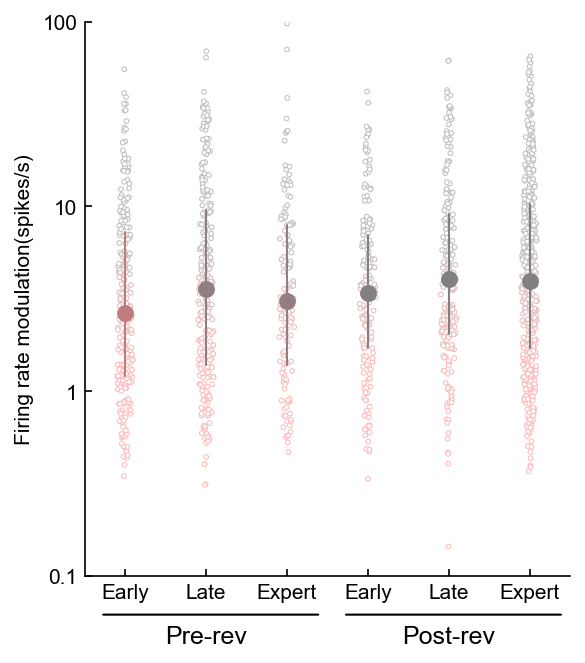

In [41]:
#Firing rate modulation graphs
size=5

FRmod_baseline_median = np.median(FRmod_preearly)
print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
data = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=0.5,zorder=-10)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color=NCR_CR_cmap((percentCR-40)/20)
    border_color = eye_color
    
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
#     border_color=colorsys.hls_to_rgb(h,l*0.5,s)
#     print(border_color)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
#Connected lines
#medians = [np.nanmedian(d) for d in data]
#ax.plot([0,1,2,3,4,5],medians[0:6],linestyle='--',color=GOOD_GREY,lw=1)

ax.set_ylim([0.1,100])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Firing rate modulation(spikes/s)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

# These animals are not performing a task, so there isn't actually a reversal
# ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
# ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, 0.054188468134356925, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
ax.text(xtick_pos_post, 0.054188468134356925, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='k'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='k'))

plt.tight_layout()
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Passive AC FRmodulation all cells over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

### V3

baseline = 3.5533237685317998


<ipython-input-60-c104a59ae4bd>:15: RuntimeWarning: divide by zero encountered in log10
  X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)


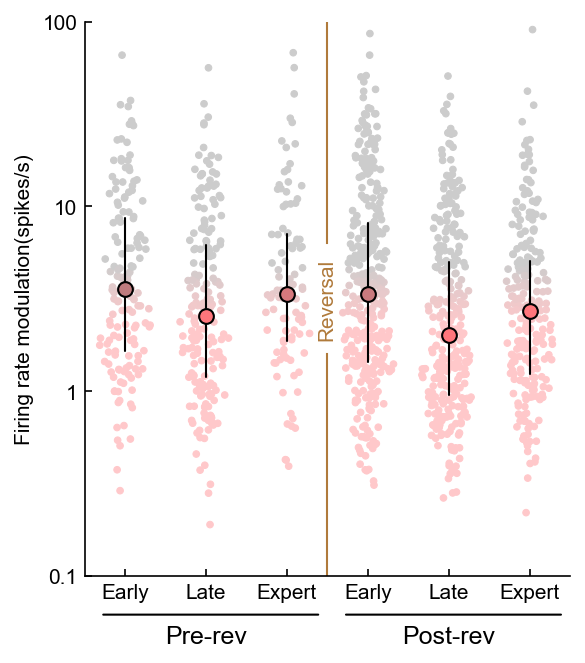

In [60]:
#Firing rate modulation graphs
size=10

#FRmod_baseline_median = np.median(FRmod_preearly)
print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
data = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.75,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)

mn = 3.5
spread = 2.5
colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )

ax.scatter(X, Y, s=size, ec=colors, fc=colors, lw=0.5,zorder=-10)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#eye_color
    
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
#     border_color=colorsys.hls_to_rgb(h,l*0.5,s)
#     print(border_color)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

    
#Connected lines
# medians = [np.nanmedian(d) for d in data]
# ax.plot([0,1,2],medians[0:3],linestyle='--',color=GOOD_GREY,lw=1)
# ax.plot([3,4,5],medians[3:6],linestyle='--',color=GOOD_GREY,lw=1)

ax.set_ylim([0.1,100])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Firing rate modulation(spikes/s)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

#bax.axs[0].text(reversal,ax.get_ylim()[1]+0.2,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='top')
size = 5
rev = 2.5
center = 10**(0.5)#center = np.mean(ax.get_ylim())
ax.text(rev,center,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center',rotation=90)
ax.plot([rev,rev],[ax.get_ylim()[0],center/2],color=SWITCH_COLOR,lw=1,linestyle='-')
ax.plot([rev,rev],[center*2,ax.get_ylim()[1]],color=SWITCH_COLOR,lw=1,linestyle='-')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.6,zorder=-5)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, 0.054188468134356925, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
ax.text(xtick_pos_post, 0.054188468134356925, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='k'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='k'))

plt.tight_layout()
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Passive AC FRmodulation all cells over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

### V5

baseline = 3.5533237685317998


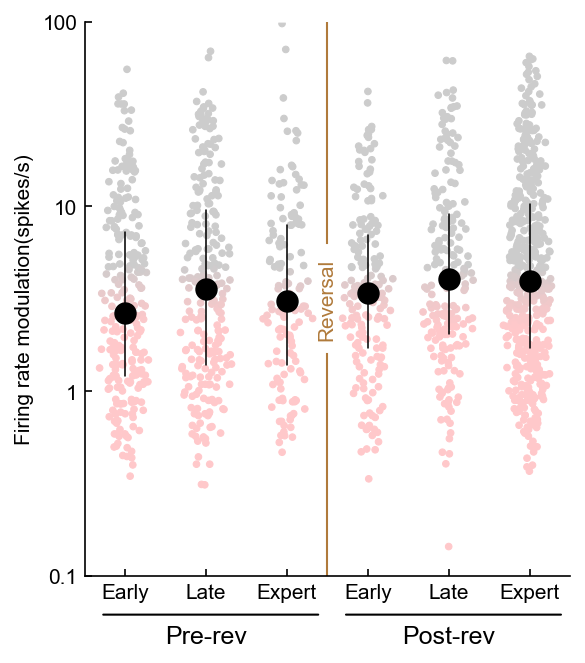

In [17]:
#Firing rate modulation graphs
size=10

#FRmod_baseline_median = np.median(FRmod_preearly)
print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
data = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.75,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)

mn = 3.5
spread = 2.5
colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )

ax.scatter(X, Y, s=size, ec=colors, fc=colors, lw=0.5,zorder=-10)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    eye_color = 'k'
    border_color = 'k'#eye_color
    
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
#     border_color=colorsys.hls_to_rgb(h,l*0.5,s)
#     print(border_color)

    summary_size=100
    summary_width=0.75
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

    
#Connected lines
# medians = [np.nanmedian(d) for d in data]
# ax.plot([0,1,2],medians[0:3],linestyle='--',color=GOOD_GREY,lw=1)
# ax.plot([3,4,5],medians[3:6],linestyle='--',color=GOOD_GREY,lw=1)

ax.set_ylim([0.1,100])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Firing rate modulation(spikes/s)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

#bax.axs[0].text(reversal,ax.get_ylim()[1]+0.2,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='top')
size = 5
rev = 2.5
center = 10**(0.5)#center = np.mean(ax.get_ylim())
ax.text(rev,center,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center',rotation=90)
ax.plot([rev,rev],[ax.get_ylim()[0],center/2],color=SWITCH_COLOR,lw=1,linestyle='-')
ax.plot([rev,rev],[center*2,ax.get_ylim()[1]],color=SWITCH_COLOR,lw=1,linestyle='-')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.6,zorder=-5)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, 0.054188468134356925, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
ax.text(xtick_pos_post, 0.054188468134356925, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='k'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='k'))

plt.tight_layout()
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Passive AC FRmodulation all cells over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

### V6

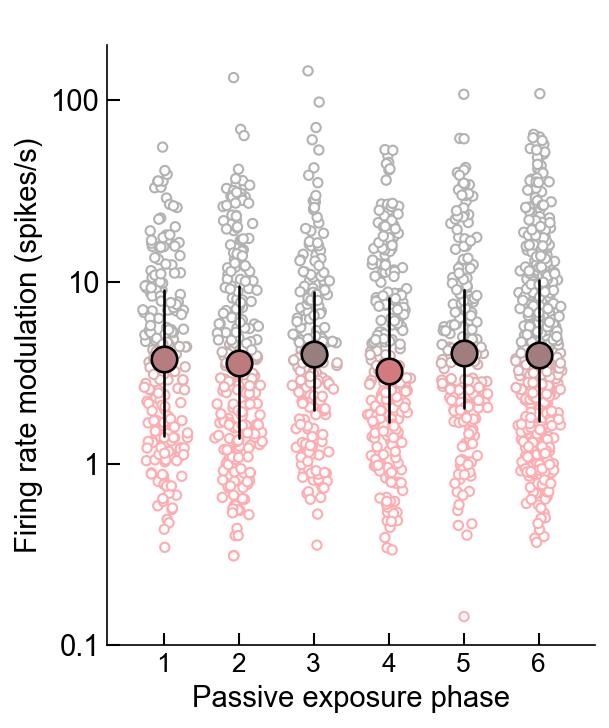

In [23]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0

################################################################################################################

size = 20
summary_size=150
summary_width=1.25#0.75

mn = 3.5
spread = 2.5
    
###
    
FRmod_baseline_median = 3.5
data = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

###

X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1]))]
_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.75,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)
colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=1,zorder=-10,clip_on=False)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    try:
        column = ilep.rmnan(column)
        percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100

        eye_color= NCR_CR_cmap((percentCR-40)/20)
        border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
    #     r,g,b = mpl.colors.to_rgb(eye_color)
    #     h,l,s = colorsys.rgb_to_hls(r,g,b)

        Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    #     median = np.mean(column)
    #     Q1 = median - sem(column)
    #     Q3 = median + sem(column)

        ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
        ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    except:
        pass
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]*1.5]*2,color='white',alpha=0.4,zorder=-5,clip_on=False)

################################################################################################################
labels = [1,2,3,4,5,6]

ax.set_ylim([0.1,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ylab = ax.set_ylabel('Firing rate modulation (spikes/s)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
xlab = ax.set_xlabel('Passive exposure phase')

# xtick_pos_pre = ax.get_xticks()[1]
# xtick_pos_post = ax.get_xticks()[4]
# Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=True)
# t1 = ax.text(xtick_pos_pre, Yval, 'Pre-rev', ha='center', va='bottom', fontsize=stdfont,color='k')
# t2 = ax.text(xtick_pos_post, Yval, 'Post-rev', ha='center', va='bottom',  fontsize=stdfont,color='k')
# ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

ttl = ax.set_title(' ')

# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,xlab,ttl]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Passive AC FRmodulation all cells over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [60]:
np.nanmean(FRmod_postearly)

7.280933140214946

In [61]:
data_dec = SimpleNamespace()
data_dec.preearly = np.abs(FRmod_preearly)
data_dec.prelate = np.abs(FRmod_prelate)
data_dec.preexpert = np.abs(FRmod_preexpert)
data_dec.postearly = np.abs(FRmod_postearly)
data_dec.postlate = np.abs(FRmod_postlate)
data_dec.postexpert = np.abs(FRmod_postexpert)
ilep.mannwhitneycompareall(data_dec)
pass

pre-early   n = 198
pre-late    n = 241
pre-expert  n = 206
post-early  n = 244
post-late   n = 201
post-expert n = 450
pre-early  to pre-late   : 0.8841567607351049
pre-late   to pre-expert : 0.4690078676873415
pre-early  to pre-expert : 0.5555582202782947
post-early to post-late  : 0.4690078676873415
post-late  to post-expert: 0.8841567607351049
post-early to post-expert: 0.4690078676873415


In [62]:
198+241+206+244+201+450

1540

In [22]:
print(np.nanmean(FRmod_preearly))
print(np.nanmean(FRmod_prelate))
print(np.nanmean(FRmod_preexpert))
print(np.nanmean(FRmod_postearly))
print(np.nanmean(FRmod_postlate))
print(np.nanmean(FRmod_postexpert))

7.12837916992917
8.388048381348499
8.4658320657163
7.280933140214946
8.730324298262657
8.82093509154874


In [22]:
print(np.nanmedian(FRmod_preearly))
print(np.nanmedian(FRmod_prelate))
print(np.nanmedian(FRmod_preexpert))
print(np.nanmedian(FRmod_postearly))
print(np.nanmedian(FRmod_postlate))
print(np.nanmedian(FRmod_postexpert))

3.7688442211055255
3.584589614740365
3.9871443940570077
3.224716318297064
4.0555555555555545
3.954929171242526


In [23]:
data_dec = SimpleNamespace()
data_dec.preearly = np.abs(FRmod_preearly)
data_dec.prelate = np.abs(FRmod_prelate)
data_dec.preexpert = np.abs(FRmod_preexpert)
data_dec.postearly = np.abs(FRmod_postearly)
data_dec.postlate = np.abs(FRmod_postlate)
data_dec.postexpert = np.abs(FRmod_postexpert)
ilep.nonparametricIndependentStatsCompareToPrevious(data_dec)
pass

            Source             SS      DF          MS         F     p-unc  \
0            phase     254.563444     3.0   84.854481  0.552893  0.646221   
1          context     215.506942     1.0  215.506942  1.404194  0.236165   
2  phase * context     190.307169     3.0   63.435723  0.413333  0.743446   
3         Residual  302957.126250  1974.0  153.473722       NaN       NaN   

        np2  
0  0.000840  
1  0.000711  
2  0.000628  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.884157  0.884157 -0.007244
8     post-late  baseline  experimental  0.166371  0.469008 -0.129772
9    pre-expert  baseline  experimental  0.234504  0.469008 -0.005499
10     pre-late  baseline  experimental  0.819991  0.884157 -0.109303
key preearly has 198 non-nan elements
key prelate has 241 non-nan elements
key preexpert has 206 non-nan elements
key postearly has 244 non-nan elements
key postlate has 201 non-nan elements
ke

In [32]:
sessionfile.meta

namespace(directory='D:\\DualRecording\\TH_237\\TH_237 5\\AC\\',
          region='AC',
          animal='TH_237',
          probe=6932,
          date='03/01/2023',
          depth=1020,
          task='tuning nonreversal',
          day_of_training=5,
          day_of_recording=5,
          first_tuning_trial=351,
          length_in_samples=71395704.0,
          files=['March 1 2023 AC Tuning TH_237_5001',
                 'March 1 2023 AC Tuning TH_237_5002',
                 'March 1 2023 AC Tuning TH_237_5003',
                 'March 1 2023 AC Tuning TH_237_5004'],
          arraystart=0,
          tonelength=0.1,
          triallength=2.5,
          lickdelayrelativetostart=0.2,
          lickdelayrelativetotone=0.1,
          fs=30000,
          length_in_seconds=2379.8568,
          length_in_minutes=39.66428,
          length_in_trials=350,
          first_tuning_trial_corrected=350)

In [48]:
len(FRmod_preearly)

245

In [49]:
len(pre_early_session)

245

In [50]:
colors = np.full_like(FRmod_preearly,np.nan)
all_sessions = np.unique(pre_early_session)
for idx,session in enumerate(pre_early_session):
    colors[idx] = np.where(np.char.equal(all_sessions,session))[0][0]

In [51]:
colors

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 7., 7.

baseline = 2.6315789473684212


<ipython-input-66-19947cff2c73>:69: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


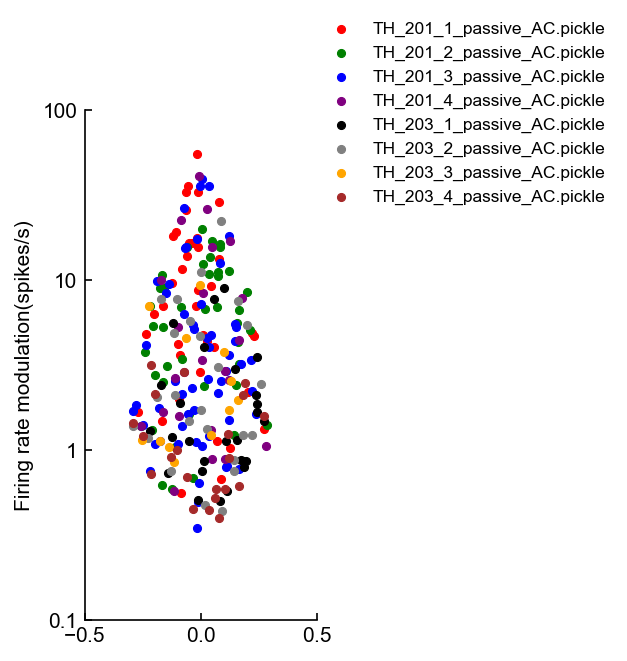

In [66]:
#Firing rate modulation graphs
size=15

FRmod_baseline_median = np.median(FRmod_preearly)
print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(2,4.5))
data = [FRmod_preearly]
labels = ['Early']
numCon = len(data)

X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.75)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75)

session_idxs = np.full_like(FRmod_preearly,np.nan)
all_sessions = np.unique(pre_early_session)
for idx,session in enumerate(pre_early_session):
    session_idxs[idx] = int(np.where(np.char.equal(all_sessions,session))[0][0])
#colors = NCR_CR_cmap((Y-1)/5)

colors = ['r','g','b','purple','k','grey','orange','brown','yellow']
for idx in range(8):
    mask = np.equal(session_idxs,idx)
    ax.scatter(X[mask], Y[mask], s=size, ec=colors[idx], fc=colors[idx], lw=0.5,zorder=-10,label=all_sessions[idx])
    
ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color=NCR_CR_cmap((percentCR-40)/20)
    border_color = eye_color

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
#     ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
#     ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
#Connected lines
#medians = [np.nanmedian(d) for d in data]
#ax.plot([0,1,2,3,4,5],medians[0:6],linestyle='--',color=GOOD_GREY,lw=1)

ax.set_ylim([0.1,100])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Firing rate modulation(spikes/s)')

ax.set_xlim([-0.5,0.5])
# ax.set_xticks(range(numCon))
# ax.set_xticklabels(labels)
# ax.set_xlim(ax.get_xlim())

# xtick_pos_pre = ax.get_xticks()[1]
# xtick_pos_post = ax.get_xticks()[4]
# ax.text(xtick_pos_pre, 0.054188468134356925, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
# ax.text(xtick_pos_post, 0.054188468134356925, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
# ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='k'))
# ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='k'))

lgd = ax.legend(frameon=False,loc=(1,0.8))

plt.tight_layout()
fig.savefig(os.path.join('D:\\\\TempFigures','Passive pre early by session V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')

baseline = 2.6315789473684212


<ipython-input-67-3549102cd2e5>:69: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


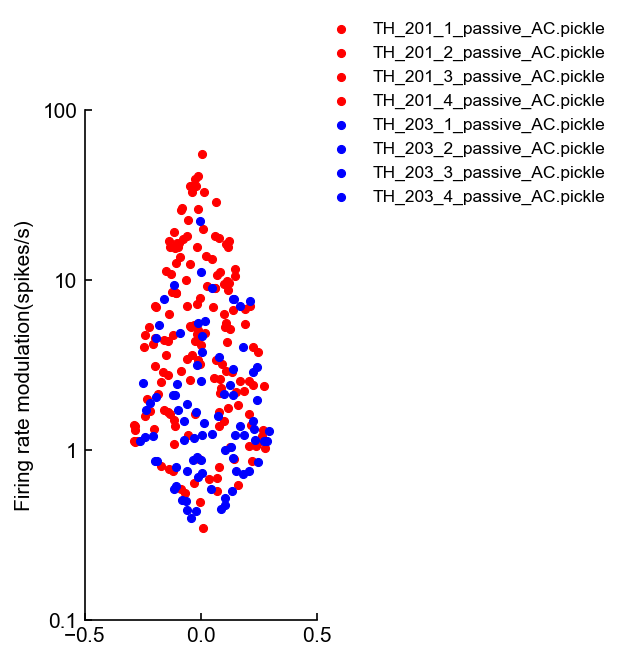

In [67]:
#Firing rate modulation graphs
size=15

FRmod_baseline_median = np.median(FRmod_preearly)
print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(2,4.5))
data = [FRmod_preearly]
labels = ['Early']
numCon = len(data)

X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.75)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75)

session_idxs = np.full_like(FRmod_preearly,np.nan)
all_sessions = np.unique(pre_early_session)
for idx,session in enumerate(pre_early_session):
    session_idxs[idx] = int(np.where(np.char.equal(all_sessions,session))[0][0])
#colors = NCR_CR_cmap((Y-1)/5)

colors = ['r','r','r','r','b','b','b','b','b']
for idx in range(8):
    mask = np.equal(session_idxs,idx)
    ax.scatter(X[mask], Y[mask], s=size, ec=colors[idx], fc=colors[idx], lw=0.5,zorder=-10,label=all_sessions[idx])
    
ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color=NCR_CR_cmap((percentCR-40)/20)
    border_color = eye_color

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
#     ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
#     ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
#Connected lines
#medians = [np.nanmedian(d) for d in data]
#ax.plot([0,1,2,3,4,5],medians[0:6],linestyle='--',color=GOOD_GREY,lw=1)

ax.set_ylim([0.1,100])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Firing rate modulation(spikes/s)')

ax.set_xlim([-0.5,0.5])
# ax.set_xticks(range(numCon))
# ax.set_xticklabels(labels)
# ax.set_xlim(ax.get_xlim())

# xtick_pos_pre = ax.get_xticks()[1]
# xtick_pos_post = ax.get_xticks()[4]
# ax.text(xtick_pos_pre, 0.054188468134356925, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
# ax.text(xtick_pos_post, 0.054188468134356925, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
# ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='k'))
# ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='k'))

lgd = ax.legend(frameon=False,loc=(1,0.8))

plt.tight_layout()
fig.savefig(os.path.join('D:\\\\TempFigures','Passive pre early by animal V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')

# Seprated by animal

In [24]:
ephys_animals = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
test_animals = ['AE_267']

In [25]:
FRmod_preearly = []
FRmod_prelate = []
FRmod_preexpert = []
FRmod_postearly = []
FRmod_postlate = []
FRmod_postexpert = []

preearly_animals = []
prelate_animals = []
preexpert_animals = []
postearly_animals = []
postlate_animals = []
postexpert_animals = []

cellstouseFR = 'all cells'
#cellstouseFR = 'task encoders'

for animal in ephys_animals:
    
    animal_FRmod_preearly = []
    animal_FRmod_prelate = []
    animal_FRmod_preexpert = []
    animal_FRmod_postearly = []
    animal_FRmod_postlate = []
    animal_FRmod_postexpert = []
    
    for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
        sessionfile = ilep.loadSessionCached(act_directory,session)

        if sessionfile.meta.animal != animal:
            continue
        
        #Currently not active as tuning curve animals have not been decoded
        if cellstouseFR == 'task encoders':
            if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
                continue

    #     if sessionfile.responsiveness[clust]['all_trials'].FR < sessionfile.responsiveness[clust]['all_trials'].FRbaseline:
    #         #print('excluded')
    #         #continue
    #         pass

        if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
            continue

        try:
            FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
        except Exception as e:
            FRmod = np.nan
            print(e)

        if EILphases[idx] == 'pre early':
            animal_FRmod_preearly.append(FRmod)
    #         Ramping_preearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
            preearly_animals.append(sessionfile.meta.animal)
        elif EILphases[idx] == 'pre late':
            animal_FRmod_prelate.append(FRmod)
    #         Ramping_prelate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
            prelate_animals.append(sessionfile.meta.animal)
        elif EILphases[idx] == 'pre expert':
            animal_FRmod_preexpert.append(FRmod)
    #         Ramping_preexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)
            preexpert_animals.append(sessionfile.meta.animal)
        elif EILphases[idx] == 'post early':
            animal_FRmod_postearly.append(FRmod)
    #         Ramping_postearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
            postearly_animals.append(sessionfile.meta.animal)
        elif EILphases[idx] == 'post late':
            animal_FRmod_postlate.append(FRmod)
    #         Ramping_postlate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
            postlate_animals.append(sessionfile.meta.animal)
        elif EILphases[idx] == 'post expert':
            animal_FRmod_postexpert.append(FRmod)
    #         Ramping_postexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)
            postexpert_animals.append(sessionfile.meta.animal)

    FRmod_preearly.append(np.nanmean(animal_FRmod_preearly))
    FRmod_prelate.append(np.nanmean(animal_FRmod_prelate))
    FRmod_preexpert.append(np.nanmean(animal_FRmod_preexpert))
    FRmod_postearly.append(np.nanmean(animal_FRmod_postearly))
    FRmod_postlate.append(np.nanmean(animal_FRmod_postlate))
    FRmod_postexpert.append(np.nanmean(animal_FRmod_postexpert))
        
FRmod_preearly = np.array(FRmod_preearly)
FRmod_prelate = np.array(FRmod_prelate)
FRmod_preexpert = np.array(FRmod_preexpert)
FRmod_postearly = np.array(FRmod_postearly)
FRmod_postlate = np.array(FRmod_postlate)
FRmod_postexpert = np.array(FRmod_postexpert)

1830it [00:30, 59.51it/s] 
<ipython-input-25-1a3b0b9362e2>:77: RuntimeWarning: Mean of empty slice
  FRmod_preearly.append(np.nanmean(animal_FRmod_preearly))
1830it [00:30, 60.35it/s] 
<ipython-input-25-1a3b0b9362e2>:78: RuntimeWarning: Mean of empty slice
  FRmod_prelate.append(np.nanmean(animal_FRmod_prelate))
<ipython-input-25-1a3b0b9362e2>:79: RuntimeWarning: Mean of empty slice
  FRmod_preexpert.append(np.nanmean(animal_FRmod_preexpert))
1830it [00:30, 60.48it/s] 
1830it [00:30, 60.27it/s] 
<ipython-input-25-1a3b0b9362e2>:80: RuntimeWarning: Mean of empty slice
  FRmod_postearly.append(np.nanmean(animal_FRmod_postearly))
1830it [00:29, 61.06it/s] 
<ipython-input-25-1a3b0b9362e2>:81: RuntimeWarning: Mean of empty slice
  FRmod_postlate.append(np.nanmean(animal_FRmod_postlate))
<ipython-input-25-1a3b0b9362e2>:82: RuntimeWarning: Mean of empty slice
  FRmod_postexpert.append(np.nanmean(animal_FRmod_postexpert))
1830it [00:30, 60.54it/s] 
1830it [00:31, 58.52it/s] 
1830it [00:30, 59.4

1
4
6
8
17
19
22
31
32
42
47
48
60
9
11
12
20
25
34
41
42
60
65
67
69
70
79
80
84


1354it [00:23, 124.97it/s]

86
93
98
99
102
105
111
112
113


1830it [00:31, 57.55it/s] 
1830it [00:31, 58.46it/s] 


In [26]:
test_FRmod_preearly = []
test_FRmod_prelate = []
test_FRmod_preexpert = []
test_FRmod_postearly = []
test_FRmod_postlate = []
test_FRmod_postexpert = []

preearly_animals = []
prelate_animals = []
preexpert_animals = []
postearly_animals = []
postlate_animals = []
postexpert_animals = []

cellstouseFR = 'all cells'
#cellstouseFR = 'task encoders'

for animal in ephys_animals:
    
    animal_FRmod_preearly = []
    animal_FRmod_prelate = []
    animal_FRmod_preexpert = []
    animal_FRmod_postearly = []
    animal_FRmod_postlate = []
    animal_FRmod_postexpert = []
    
    for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
        sessionfile = ilep.loadSessionCached(act_directory,session)

        if sessionfile.meta.animal != animal:
            continue
        
        #Currently not active as tuning curve animals have not been decoded
        if cellstouseFR == 'task encoders':
            if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
                continue

    #     if sessionfile.responsiveness[clust]['all_trials'].FR < sessionfile.responsiveness[clust]['all_trials'].FRbaseline:
    #         #print('excluded')
    #         #continue
    #         pass

        if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
            continue

        try:
            FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
        except Exception as e:
            FRmod = np.nan
            print(e)

        if EILphases[idx] == 'pre early':
            animal_FRmod_preearly.append(FRmod)
    #         Ramping_preearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
            preearly_animals.append(sessionfile.meta.animal)
        elif EILphases[idx] == 'pre late':
            animal_FRmod_prelate.append(FRmod)
    #         Ramping_prelate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
            prelate_animals.append(sessionfile.meta.animal)
        elif EILphases[idx] == 'pre expert':
            animal_FRmod_preexpert.append(FRmod)
    #         Ramping_preexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)
            preexpert_animals.append(sessionfile.meta.animal)
        elif EILphases[idx] == 'post early':
            animal_FRmod_postearly.append(FRmod)
    #         Ramping_postearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
            postearly_animals.append(sessionfile.meta.animal)
        elif EILphases[idx] == 'post late':
            animal_FRmod_postlate.append(FRmod)
    #         Ramping_postlate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
            postlate_animals.append(sessionfile.meta.animal)
        elif EILphases[idx] == 'post expert':
            animal_FRmod_postexpert.append(FRmod)
    #         Ramping_postexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)
            postexpert_animals.append(sessionfile.meta.animal)

    test_FRmod_preearly.append(np.nanmean(animal_FRmod_preearly))
    test_FRmod_prelate.append(np.nanmean(animal_FRmod_prelate))
    test_FRmod_preexpert.append(np.nanmean(animal_FRmod_preexpert))
    test_FRmod_postearly.append(np.nanmean(animal_FRmod_postearly))
    test_FRmod_postlate.append(np.nanmean(animal_FRmod_postlate))
    test_FRmod_postexpert.append(np.nanmean(animal_FRmod_postexpert))
        
test_FRmod_preearly = np.array(test_FRmod_preearly)
test_FRmod_prelate = np.array(test_FRmod_prelate)
test_FRmod_preexpert = np.array(test_FRmod_preexpert)
test_FRmod_postearly = np.array(test_FRmod_postearly)
test_FRmod_postlate = np.array(test_FRmod_postlate)
test_FRmod_postexpert = np.array(test_FRmod_postexpert)

1830it [00:30, 59.50it/s] 
<ipython-input-26-7a8b125b921b>:77: RuntimeWarning: Mean of empty slice
  test_FRmod_preearly.append(np.nanmean(animal_FRmod_preearly))
1830it [00:30, 59.75it/s] 
<ipython-input-26-7a8b125b921b>:78: RuntimeWarning: Mean of empty slice
  test_FRmod_prelate.append(np.nanmean(animal_FRmod_prelate))
<ipython-input-26-7a8b125b921b>:79: RuntimeWarning: Mean of empty slice
  test_FRmod_preexpert.append(np.nanmean(animal_FRmod_preexpert))
1830it [00:31, 57.65it/s] 
1830it [00:31, 57.81it/s] 
<ipython-input-26-7a8b125b921b>:80: RuntimeWarning: Mean of empty slice
  test_FRmod_postearly.append(np.nanmean(animal_FRmod_postearly))
1830it [00:31, 57.74it/s] 
<ipython-input-26-7a8b125b921b>:81: RuntimeWarning: Mean of empty slice
  test_FRmod_postlate.append(np.nanmean(animal_FRmod_postlate))
<ipython-input-26-7a8b125b921b>:82: RuntimeWarning: Mean of empty slice
  test_FRmod_postexpert.append(np.nanmean(animal_FRmod_postexpert))
1830it [00:31, 58.06it/s] 
1830it [00:32, 5

1
4
6
8
17
19
22
31
32
42
47
48
60
9
11
12
20
25
34
41
42
60
65
67
69
70
79
80
84


1357it [00:23, 110.95it/s]

86
93
98
99
102
105
111
112
113


1830it [00:31, 58.60it/s] 
1830it [00:31, 58.65it/s] 


In [70]:
for session in np.unique(EnumACSession):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
#     if sessionfile.meta.day_of_training not in [9,10,11,12]:
#         continue
    if sessionfile.meta.animal != 'LA_204':
        continue
    
    FRmods = []
    for clust in sessionfile.clusters.good:
        FRmods.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
    print(f"session {session} has {100-100*np.mean(np.greater_equal(FRmods,3.5))}% NCRs and mean responsiveness {np.mean(FRmods)} with {len(FRmods)} cells")

session LA_204_2_passive_AC.pickle has 40.0% NCRs and mean responsiveness 4.632007693054771 with 25 cells
session LA_204_3_passive_AC.pickle has 59.375% NCRs and mean responsiveness 3.6127951132346277 with 32 cells
session LA_204_5_passive_AC.pickle has 47.05882352941176% NCRs and mean responsiveness 10.293903470507464 with 17 cells
session LA_204_6_passive_AC.pickle has 29.411764705882348% NCRs and mean responsiveness 8.068394513065956 with 17 cells
session LA_204_7_passive_AC.pickle has 0.0% NCRs and mean responsiveness 7.61904761904762 with 1 cells


In [31]:
means = []

for session in np.unique(EnumACSession):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    FRmods = []
    for clust in sessionfile.clusters.good:
        FRmods.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
    print(f"session {session} has mean responsiveness {np.mean(FRmods)}")
    means.append(np.mean(FRmods))

session AE_229_1_passive_AC.pickle has mean responsiveness 7.6957892493774995
session AE_229_2_passive_AC.pickle has mean responsiveness 7.58842581144674
session AE_229_3_passive_AC.pickle has mean responsiveness 11.857194318441623
session AE_229_4_passive_AC.pickle has mean responsiveness 14.213706424135212
session AE_229_5_passive_AC.pickle has mean responsiveness 6.015872856286156
session AE_229_6_passive_AC.pickle has mean responsiveness 7.744426578427526
session AE_229_7_passive_AC.pickle has mean responsiveness 7.312649915239463
session LA_204_2_passive_AC.pickle has mean responsiveness 4.632007693054771
session LA_204_3_passive_AC.pickle has mean responsiveness 3.6127951132346277
session LA_204_4_passive_AC.pickle has mean responsiveness 2.047492037355878
session LA_204_5_passive_AC.pickle has mean responsiveness 10.293903470507464
session LA_204_6_passive_AC.pickle has mean responsiveness 8.068394513065956
session LA_204_7_passive_AC.pickle has mean responsiveness 7.61904761904

(array([2., 0., 1., 2., 1., 1., 1., 1., 2., 0., 2., 1., 2., 0., 4., 3., 2.,
        1., 5., 2., 0., 0., 2., 0., 0., 2., 1., 0., 0., 2., 4., 0., 0., 1.,
        1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 0.93802345,  1.30065402,  1.6632846 ,  2.02591517,  2.38854574,
         2.75117631,  3.11380688,  3.47643746,  3.83906803,  4.2016986 ,
         4.56432917,  4.92695975,  5.28959032,  5.65222089,  6.01485146,
         6.37748204,  6.74011261,  7.10274318,  7.46537375,  7.82800433,
         8.1906349 ,  8.55326547,  8.91589604,  9.27852661,  9.64115719,
        10.00378776, 10.36641833, 10.7290489 , 11.09167948, 11.45431005,
        11.81694062, 12.17957119, 12.54220177, 12.90483234, 13.26746291,
        13.63009348, 13.99272405, 14.35535463, 14.7179852 , 15.08061577,
        15.44324634, 15.80587692, 16.16850749, 16.53113806, 16.89376863,
        17.25639921, 17.61902978, 17.98166035, 18.34429092, 18.7069215 ,
        19.06955207]),
 <BarContainer object

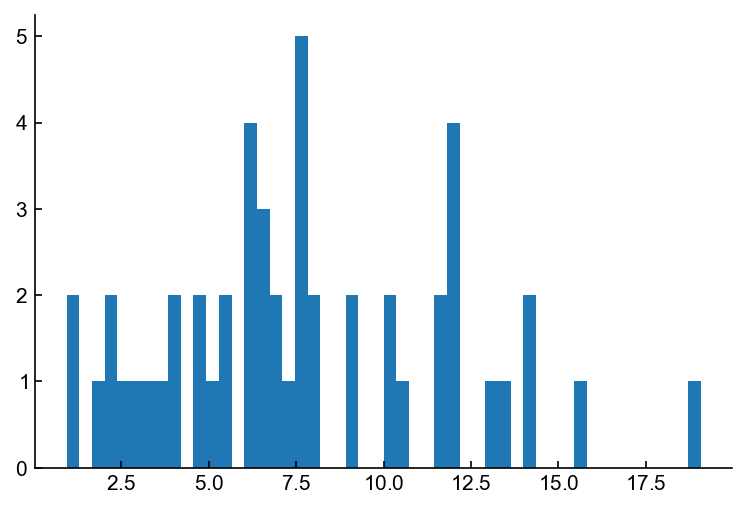

In [34]:
plt.hist(means,bins=50)

In [119]:
n = []
for session in np.unique(EnumSession):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    n.append(len(sessionfile.clusters.good))

In [120]:
np.median(n)

10.0

In [121]:
np.mean(n)

13.863636363636363

In [122]:
np.std(n)

11.29881512108663

(array([24., 22., 16.,  7., 10., 11.,  6.,  5.,  7.,  5.,  7.,  6.,  0.,
         1.,  3.,  0.,  0.,  0.,  1.,  1.]),
 array([ 1. ,  3.7,  6.4,  9.1, 11.8, 14.5, 17.2, 19.9, 22.6, 25.3, 28. ,
        30.7, 33.4, 36.1, 38.8, 41.5, 44.2, 46.9, 49.6, 52.3, 55. ]),
 <BarContainer object of 20 artists>)

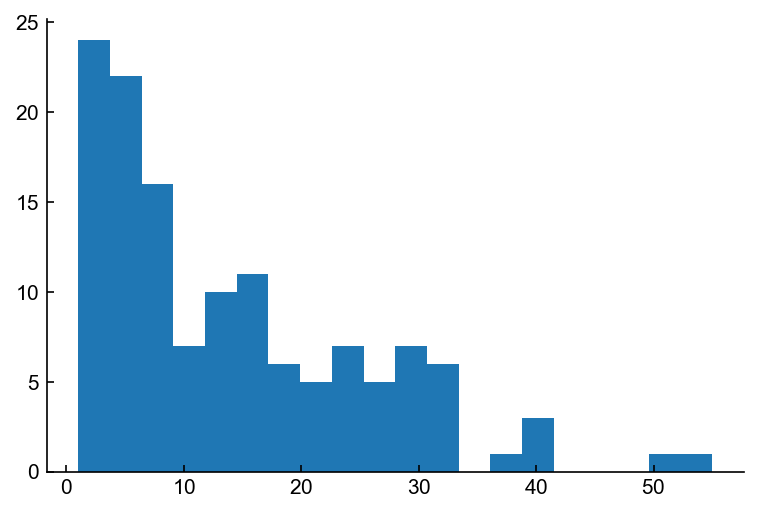

In [124]:
plt.hist(n,bins=20)

In [125]:
np.sort(n)

array([ 1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,
        5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 11,
       11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 14, 15, 15, 15, 15, 15, 16,
       16, 16, 16, 16, 17, 18, 19, 19, 19, 19, 19, 20, 20, 20, 21, 22, 23,
       23, 23, 24, 25, 25, 25, 26, 26, 27, 27, 27, 28, 28, 29, 29, 29, 30,
       30, 31, 31, 31, 31, 31, 32, 38, 39, 40, 40, 52, 55])

In [127]:
np.cumsum(np.sort(n))

array([   1,    2,    3,    4,    5,    6,    8,   10,   12,   14,   16,
         18,   20,   22,   24,   26,   28,   31,   34,   37,   40,   43,
         46,   49,   53,   57,   61,   65,   69,   73,   77,   81,   86,
         91,   96,  101,  106,  111,  116,  122,  128,  134,  140,  146,
        152,  158,  165,  172,  179,  187,  195,  203,  211,  219,  227,
        235,  244,  253,  262,  271,  280,  289,  299,  309,  319,  329,
        339,  350,  361,  373,  385,  397,  409,  421,  434,  447,  460,
        473,  487,  502,  517,  532,  547,  562,  578,  594,  610,  626,
        642,  659,  677,  696,  715,  734,  753,  772,  792,  812,  832,
        853,  875,  898,  921,  944,  968,  993, 1018, 1043, 1069, 1095,
       1122, 1149, 1176, 1204, 1232, 1261, 1290, 1319, 1349, 1379, 1410,
       1441, 1472, 1503, 1534, 1566, 1604, 1643, 1683, 1723, 1775, 1830],
      dtype=int32)

In [40]:
np.log10(200)

2.3010299956639813

# Per-Phase Histograms

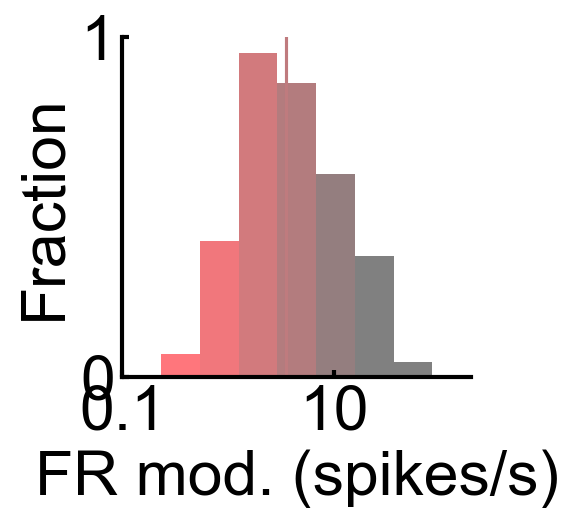

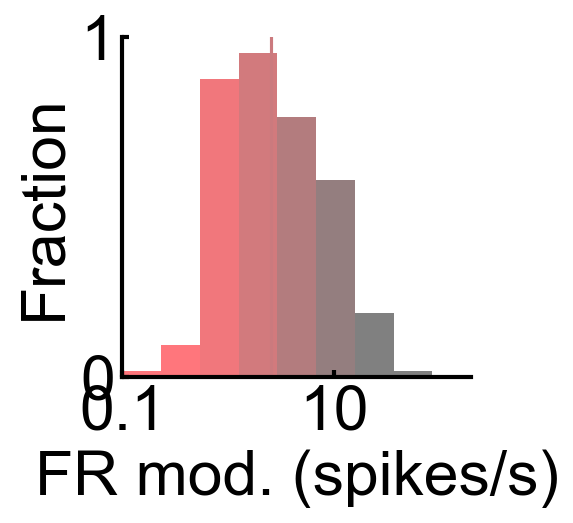

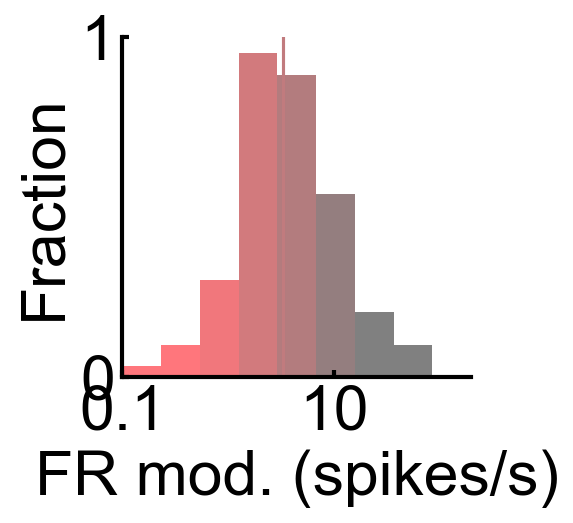

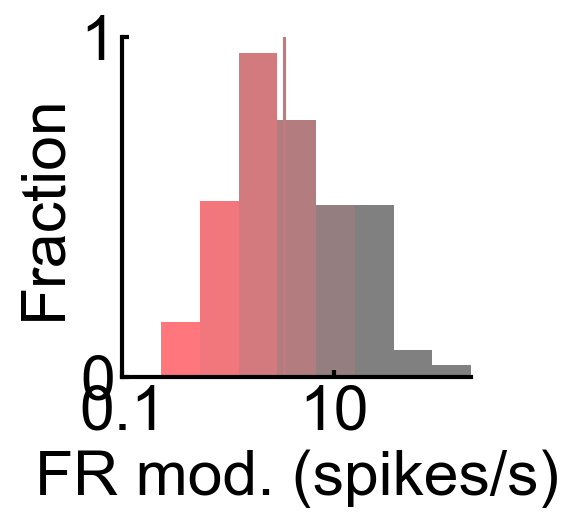

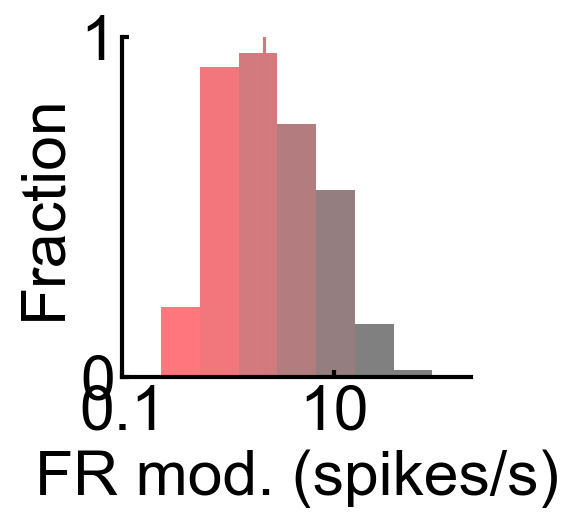

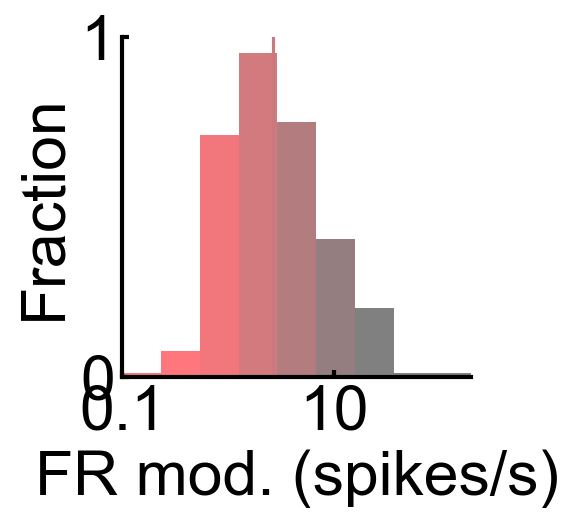

In [22]:
mn = np.log10(3.5)
spread = 1.5

for phase,phase_data in zip(['pre early','pre late','pre expert','post early','post late','post expert'],[FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]):
    fig,ax = plt.subplots(figsize=(3,3))

    data = phase_data
    data[data==0] = 0.1
    data = np.log10(data)
    
    counts,edges = np.histogram(ilep.rmnan(data),bins=9,range=[-1,np.log10(200)])
    for idx,count in enumerate(counts):
        FRmod = np.mean([10**edges[idx],10**edges[idx+1]])
        color = NCR_CR_cmap( (np.log10(FRmod)-(mn-spread/2))/ (spread) )
        ax.fill_between([edges[idx],edges[idx+1]],[count],color=color,lw=0)
#     ax.hist(data,bins=10,log=False)

    ax.axvline(np.log10(np.median(ilep.rmnan(phase_data))),color=NCR_CR_cmap( (np.log10(np.median(ilep.rmnan(phase_data)))-(mn-spread/2))/ (spread) ))

    ax.set_xlim([-1,np.log10(200)])
    ax.set_xticks([-1,1])
    ax.set_xticklabels([0.1,10])

    ylims = ax.get_ylim()
    ylims = (0,ylims[1])
    ax.set_ylim(ylims)
    ax.set_yticks(ylims)
    ax.set_yticklabels([0,1])
    
    xlab = ax.set_xlabel('FR mod. (spikes/s)')
    ylab = ax.set_ylabel('Fraction')
#     ax.set_title(phase)
    
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(2)
    ax.tick_params(width=2)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(30)
        
    artists = [xlab,ylab]
    fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Histogram for phase '+phase+' V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')